In [1]:
import torch as t
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 

Use GPU to accelerate the computing if available.

In [2]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

Load MNIST data and regularize them from [0,255] to [0,1].

In [3]:
train_data = tv.datasets.MNIST(
    './MNIST_data',train = True,transform = transforms.ToTensor(),download = False)
test_data = tv.datasets.MNIST(
    './MNIST_data',train = False,transform = transforms.ToTensor(),download = False)
train_data.train_data = train_data.train_data.view(60000,-1).float()/255
test_data.test_data = test_data.test_data.view(10000,-1).float()/255

The softmax model, a generalized logistic regression model for multi-classification, is implemented in this module named Softmax.  
Given a batch of data, this module will return the hypotheses of the data.

In [4]:
class Softmax(nn.Module):
    def __init__(self):
        super(Softmax,self).__init__()
        self.linear = nn.Linear(784,10)
        self.linear.weight.data = 0.1*t.randn(10,784)
        self.linear.bias.data = 0.1*t.randn(10)
        
    def forward(self,x):
        x = self.linear(x)
        x = t.exp(x)
        x = x/(x.sum(-1,keepdim = True))
        return x

Given a batch of hypotheses and its corresponding labels, loss_function returns the cross-entropy loss.

In [5]:
def loss_function(softmax_x,y):
    batch_size = softmax_x.size()[0]
    index1 = t.arange(0,batch_size,1)
    index2 = y
    entropy = t.log(softmax_x[index1,index2])
    loss = -entropy.sum()/batch_size
    return loss

Given a trained model, evaluation returns its prediction accuracy on the given data.

In [6]:
def evaluation(model,data,label):
    with t.no_grad():
        probabilities = model(data.to(device))
        prediction = probabilities.max(1)[1]
        prediction = prediction.cpu().numpy()
        count = (prediction == label).sum()
        accuracy = count.float()/label.size()[0]
        return accuracy.item()

# 1. Gradient Descent

In this part, a gradient descent method will be implemented and then applied to train the softmax model.

In [7]:
def gradient_descent(parameters,learning_rate):
    gradient = parameters.grad
    parameters.data -= learning_rate*gradient

The distance between current parameters and the optimal parameters is given by the Frobenius norm of the differences.

In [8]:
def dist(para1,para2):
    differences = para1-para2
    norm = np.sqrt((differences**2).sum())
    return norm

In [9]:
max_steps1 = 1500
learning_rate_list = [1,0.5,0.1,0.05,0.01,0.005,0.001]
para_list1 = []
accuracy_list1 = []

Training is terminated if max number of steps is reached.

In [10]:
x = train_data.train_data.to(device)
y = train_data.train_labels

for learning_rate in learning_rate_list:
    softmax = Softmax()
    softmax.to(device)
    para_list = []
    accuracy_list = []
    print('Training of learning rate {} starts:'.format(learning_rate))
    
    for i in range(max_steps1):
        softmax_x = softmax(x)

        if softmax.linear.weight.grad is not None:
            t.zero_(softmax.linear.weight.grad)
        if softmax.linear.bias.grad is not None:
            t.zero_(softmax.linear.bias.grad)  

        loss = loss_function(softmax_x,y)
        loss.backward()
        gradient_descent(softmax.linear.weight,learning_rate)
        gradient_descent(softmax.linear.bias,learning_rate)

        para_list.append(softmax.linear.weight.data.cpu().numpy())
        accuracy = evaluation(softmax,test_data.test_data,test_data.test_labels)
        accuracy_list.append(accuracy)

        if i%500 == 499:
            print("    Steps {} out of {} finished.".format(i+1,max_steps1))

    print('Reach max number of steps, training of learning rate {} ends.\n'.format(learning_rate))
    para_list1.append(para_list)
    accuracy_list1.append(accuracy_list)

Training of learning rate 1 starts:
    Steps 500 out of 1500 finished.
    Steps 1000 out of 1500 finished.
    Steps 1500 out of 1500 finished.
Reach max number of steps, training of learning rate 1 ends.

Training of learning rate 0.5 starts:
    Steps 500 out of 1500 finished.
    Steps 1000 out of 1500 finished.
    Steps 1500 out of 1500 finished.
Reach max number of steps, training of learning rate 0.5 ends.

Training of learning rate 0.1 starts:
    Steps 500 out of 1500 finished.
    Steps 1000 out of 1500 finished.
    Steps 1500 out of 1500 finished.
Reach max number of steps, training of learning rate 0.1 ends.

Training of learning rate 0.05 starts:
    Steps 500 out of 1500 finished.
    Steps 1000 out of 1500 finished.
    Steps 1500 out of 1500 finished.
Reach max number of steps, training of learning rate 0.05 ends.

Training of learning rate 0.01 starts:
    Steps 500 out of 1500 finished.
    Steps 1000 out of 1500 finished.
    Steps 1500 out of 1500 finished.
Reach

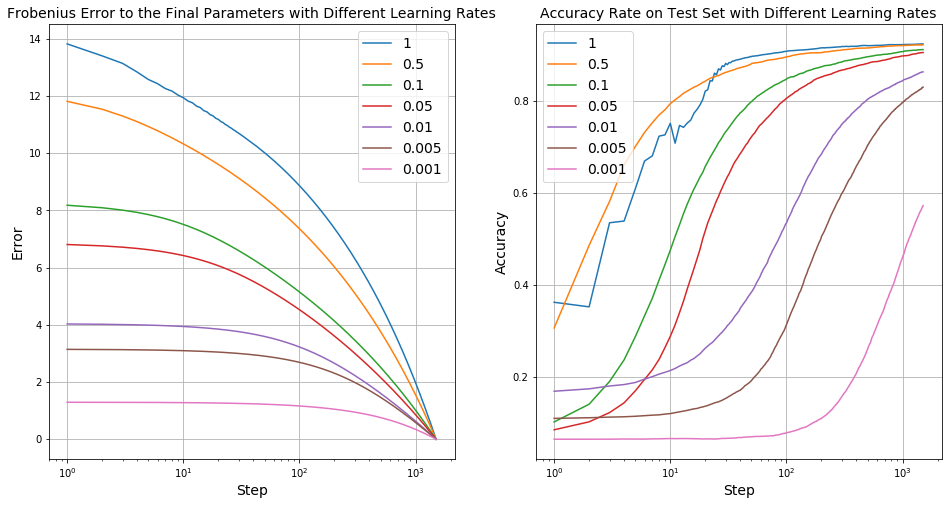

After 1500 steps, the final accuracy rates are:
Learning rate of 1: 0.9243000149726868
Learning rate of 0.5: 0.9225999712944031
Learning rate of 0.1: 0.9121000170707703
Learning rate of 0.05: 0.9057000279426575
Learning rate of 0.01: 0.8636999726295471
Learning rate of 0.005: 0.8303999900817871
Learning rate of 0.001: 0.5730999708175659


In [11]:
plt.figure(figsize = (16,8))

step_index1 = np.linspace(1,max_steps1,max_steps1)

plt.subplot(121)
for i in range(len(learning_rate_list)):
    dist_list = [dist(para,para_list1[i][-1]) for para in para_list1[i]]
    plt.plot(step_index1,dist_list,'-',label = str(learning_rate_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xscale('log')
plt.title('Frobenius Error to the Final Parameters with Different Learning Rates',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.subplot(122)
for i in range(len(learning_rate_list)):
    plt.plot(step_index1,accuracy_list1[i],'-',label = str(learning_rate_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.xscale('log')
plt.title('Accuracy Rate on Test Set with Different Learning Rates',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.show()
print('After {} steps, the final accuracy rates are:'.format(max_steps1))
for i in range(len(learning_rate_list)):
    print('Learning rate of {}: {}'.format(learning_rate_list[i],accuracy_list1[i][-1]))

# 2. Stochastic Gradient Descent

In [21]:
max_steps2 = 2000
batch_list = [10,50,100,500,1000,5000,10000]
learning_rate2 = 2.5
para_list2 = []
accuracy_list2 = []

Training is terminated if max number of steps is reached.

In [22]:
for batch_size in batch_list:
    softmax = Softmax()
    softmax.to(device)
    para_list = []
    accuracy_list = []
    print('Training of batch size {} starts:'.format(batch_size))
    
    for i in range(max_steps2):
        batch_index = np.random.randint(0,60000,batch_size)

        batch_x = train_data.train_data[batch_index].to(device)
        batch_y = train_data.train_labels[batch_index]
        softmax_x = softmax(batch_x)

        if softmax.linear.weight.grad is not None:
            t.zero_(softmax.linear.weight.grad)
        if softmax.linear.bias.grad is not None:
            t.zero_(softmax.linear.bias.grad)  

        loss = loss_function(softmax_x,batch_y)
        loss.backward()
        #lr = t.tensor(learning_rate2/(np.sqrt(i+1))).to(device)
        lr = t.tensor(learning_rate2/(i+1)).to(device)
        gradient_descent(softmax.linear.weight,lr)
        gradient_descent(softmax.linear.bias,lr)

        para_list.append(softmax.linear.weight.data.cpu().numpy())
        accuracy = evaluation(softmax,test_data.test_data,test_data.test_labels)
        accuracy_list.append(accuracy)

        if i%500 == 499:
            print("    Steps {} out of {} finished.".format(i+1,max_steps2))
    
    print('Reach max number of steps, training of batch size {} ends.\n'.format(batch_size))
    para_list2.append(para_list)
    accuracy_list2.append(accuracy_list)

Training of batch size 10 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 10 ends.

Training of batch size 50 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 50 ends.

Training of batch size 100 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 100 ends.

Training of batch size 500 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 500 ends.

Training of batch size 1000 star

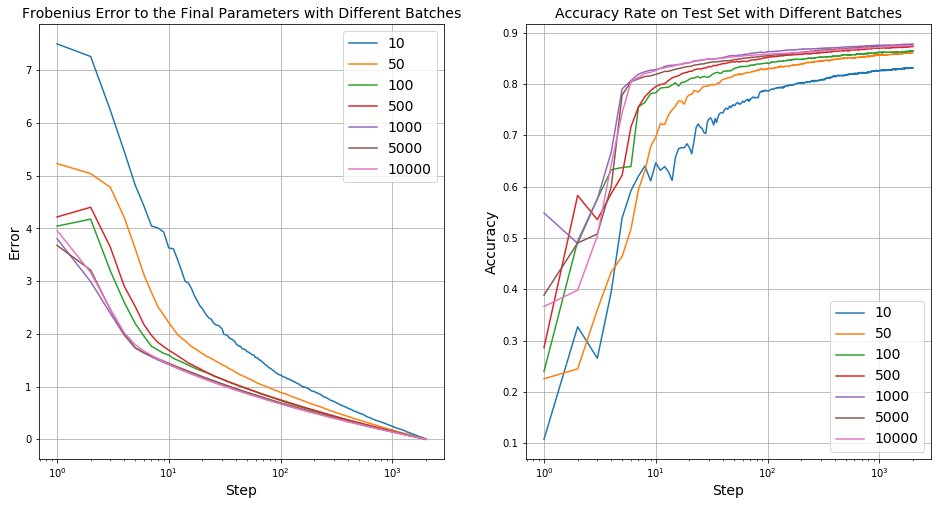

After 2000 steps with learning rate of 2.5, the final accuracy rates are:
Batch size of 10: 0.8317000269889832
Batch size of 50: 0.8608999848365784
Batch size of 100: 0.864799976348877
Batch size of 500: 0.8730000257492065
Batch size of 1000: 0.8781999945640564
Batch size of 5000: 0.8756999969482422
Batch size of 10000: 0.8751000165939331


In [23]:
plt.figure(figsize = (16,8))

step_index2 = np.linspace(1,max_steps2,max_steps2)

plt.subplot(121)
for i in range(len(batch_list)):
    dist_list = [dist(para,para_list2[i][-1]) for para in para_list2[i]]
    plt.plot(step_index2,dist_list,'-',label = str(batch_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xscale('log')
plt.title('Frobenius Error to the Final Parameters with Different Batches',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.subplot(122)
for i in range(len(batch_list)):
    plt.plot(step_index2,accuracy_list2[i],'-',label = str(batch_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.xscale('log')
plt.title('Accuracy Rate on Test Set with Different Batches',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.show()

print('After {} steps with learning rate of {}, the final accuracy rates are:'.format(max_steps2,learning_rate2))
for i in range(len(batch_list)):
    print('Batch size of {}: {}'.format(batch_list[i],accuracy_list2[i][-1]))

In [18]:
max_steps2 = 2000
batch_list = [10,50,100,500,1000,5000,10000]
learning_rate2 = 2.5
para_list2 = []
accuracy_list2 = []

In [19]:
for batch_size in batch_list:
    softmax = Softmax()
    softmax.to(device)
    para_list = []
    accuracy_list = []
    print('Training of batch size {} starts:'.format(batch_size))
    
    for i in range(max_steps2):
        batch_index = np.random.randint(0,60000,batch_size)

        batch_x = train_data.train_data[batch_index].to(device)
        batch_y = train_data.train_labels[batch_index]
        softmax_x = softmax(batch_x)

        if softmax.linear.weight.grad is not None:
            t.zero_(softmax.linear.weight.grad)
        if softmax.linear.bias.grad is not None:
            t.zero_(softmax.linear.bias.grad)  

        loss = loss_function(softmax_x,batch_y)
        loss.backward()
        #lr = t.tensor(learning_rate2/(np.sqrt(i+1))).to(device)
        lr = t.tensor(learning_rate2/(i+1)).to(device)
        gradient_descent(softmax.linear.weight,lr)
        gradient_descent(softmax.linear.bias,lr)

        para_list.append(softmax.linear.weight.data.cpu().numpy())
        accuracy = evaluation(softmax,test_data.test_data,test_data.test_labels)
        accuracy_list.append(accuracy)

        if i%500 == 499:
            print("    Steps {} out of {} finished.".format(i+1,max_steps2))
    
    print('Reach max number of steps, training of batch size {} ends.\n'.format(batch_size))
    para_list2.append(para_list)
    accuracy_list2.append(accuracy_list)

Training of batch size 10 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 10 ends.

Training of batch size 50 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 50 ends.

Training of batch size 100 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 100 ends.

Training of batch size 500 starts:
    Steps 500 out of 2000 finished.
    Steps 1000 out of 2000 finished.
    Steps 1500 out of 2000 finished.
    Steps 2000 out of 2000 finished.
Reach max number of steps, training of batch size 500 ends.

Training of batch size 1000 star

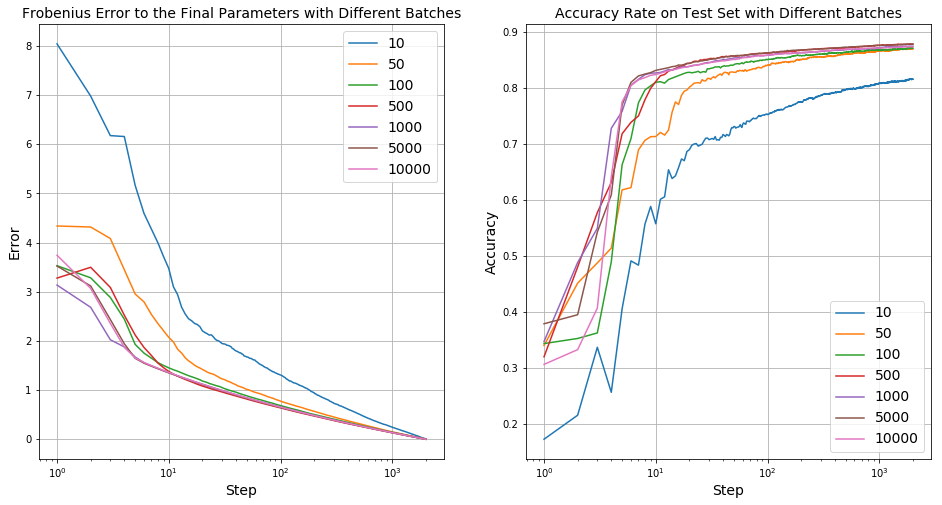

After 2000 steps with learning rate of 2.5, the final accuracy rates are:
Batch size of 10: 0.8154000043869019
Batch size of 50: 0.8690999746322632
Batch size of 100: 0.8704000115394592
Batch size of 500: 0.8774999976158142
Batch size of 1000: 0.8740000128746033
Batch size of 5000: 0.8780999779701233
Batch size of 10000: 0.8730000257492065


In [20]:
plt.figure(figsize = (16,8))

step_index2 = np.linspace(1,max_steps2,max_steps2)

plt.subplot(121)
for i in range(len(batch_list)):
    dist_list = [dist(para,para_list2[i][-1]) for para in para_list2[i]]
    plt.plot(step_index2,dist_list,'-',label = str(batch_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Error',fontsize = 14)
plt.xscale('log')
plt.title('Frobenius Error to the Final Parameters with Different Batches',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.subplot(122)
for i in range(len(batch_list)):
    plt.plot(step_index2,accuracy_list2[i],'-',label = str(batch_list[i]))
plt.xlabel('Step',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.xscale('log')
plt.title('Accuracy Rate on Test Set with Different Batches',fontsize = 14)
plt.legend(loc = 'best',fontsize = 14)
plt.grid(True)

plt.show()

print('After {} steps with learning rate of {}, the final accuracy rates are:'.format(max_steps2,learning_rate2))
for i in range(len(batch_list)):
    print('Batch size of {}: {}'.format(batch_list[i],accuracy_list2[i][-1]))